# Comparaison Multi-Modeles Audio

**Module :** 03-Audio-Orchestration  
**Niveau :** Avance  
**Technologies :** Whisper API vs local, OpenAI TTS vs Chatterbox vs Kokoro, ~12 GB VRAM  
**Duree estimee :** 60 minutes  

## Objectifs d'Apprentissage

- [ ] Construire un framework de benchmark pour les modeles audio (timing, qualite, cout)
- [ ] Comparer les modeles STT : Whisper API vs faster-whisper local (precision, vitesse, cout)
- [ ] Comparer les modeles TTS : OpenAI vs Chatterbox vs Kokoro (naturalite, vitesse, VRAM)
- [ ] Visualiser les resultats avec matplotlib (bar charts, radar plots)
- [ ] Analyser les couts API vs GPU local
- [ ] Choisir le modele optimal selon le cas d'usage

## Prerequis

- Notebooks 01-1 a 01-5 recommandes (fondamentaux audio)
- Notebooks 02-1 recommande (Chatterbox)
- GPU NVIDIA avec au moins 12 GB VRAM (pour tous les modeles locaux)
- Cle API OpenAI configuree (`OPENAI_API_KEY` dans `.env`)
- `pip install faster-whisper chatterbox-tts kokoro soundfile matplotlib`

**Navigation :** [<< 02-4](../02-Advanced/02-4-Demucs-Source-Separation.ipynb) | [Index](../README.md) | [Suivant >>](03-2-Audio-Pipeline-Orchestration.ipynb)

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres benchmark
run_stt_benchmark = True           # Executer le benchmark STT
run_tts_benchmark = True           # Executer le benchmark TTS
stt_models = ["whisper-1", "large-v3-turbo"]  # Modeles STT a comparer
tts_models = ["openai", "chatterbox", "kokoro"]  # Modeles TTS a comparer
device = "cuda"                    # "cuda" ou "cpu"

# Configuration
save_results = True                # Sauvegarder les fichiers generes
num_runs = 3                       # Nombre de runs par modele pour moyenner

In [2]:
# Setup environnement et imports
import os
import sys
import json
import time
import gc
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional
import logging

import numpy as np
import soundfile as sf
from IPython.display import Audio, display, HTML

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.audio_helpers import play_audio, save_audio
        print("Helpers audio importes")
    except ImportError:
        print("Helpers audio non disponibles - mode autonome")

# Repertoires
OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'audio' / 'comparison'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('audio_comparison')

# Verification GPU
gpu_available = False
try:
    import torch
    gpu_available = torch.cuda.is_available()
    if gpu_available:
        gpu_name = torch.cuda.get_device_name(0)
        gpu_vram = torch.cuda.get_device_properties(0).total_mem / (1024**3)
        print(f"GPU : {gpu_name} ({gpu_vram:.1f} GB VRAM)")
    else:
        print("GPU non disponible - les modeles locaux seront plus lents")
        if device == "cuda":
            device = "cpu"
            print("Fallback vers CPU")
except ImportError:
    print("torch non installe")
    device = "cpu"

print(f"\nComparaison Multi-Modeles Audio")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}, Device : {device}")
print(f"STT : {stt_models}")
print(f"TTS : {tts_models}")
print(f"Sortie : {OUTPUT_DIR}")

Helpers audio importes


GPU non disponible - les modeles locaux seront plus lents
Fallback vers CPU

Comparaison Multi-Modeles Audio
Date : 2026-02-18 10:48:52
Mode : interactive, Device : cpu
STT : ['whisper-1', 'large-v3-turbo']
TTS : ['openai', 'chatterbox', 'kokoro']
Sortie : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\audio\comparison


In [3]:
# Chargement .env et validation API
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Validation cle OpenAI (necessaire pour Whisper API et OpenAI TTS)
openai_key = os.getenv('OPENAI_API_KEY')
openai_available = False

if openai_key:
    try:
        from openai import OpenAI
        client = OpenAI(api_key=openai_key)
        openai_available = True
        print(f"OPENAI_API_KEY valide - API disponible")
    except Exception as e:
        print(f"Erreur OpenAI : {str(e)[:100]}")
else:
    print("OPENAI_API_KEY non disponible - benchmarks API desactives")
    # Retirer les modeles API si pas de cle
    if "whisper-1" in stt_models:
        stt_models = [m for m in stt_models if m != "whisper-1"]
    if "openai" in tts_models:
        tts_models = [m for m in tts_models if m != "openai"]

print(f"\nModeles STT actifs : {stt_models}")
print(f"Modeles TTS actifs : {tts_models}")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env


OPENAI_API_KEY valide - API disponible

Modeles STT actifs : ['whisper-1', 'large-v3-turbo']
Modeles TTS actifs : ['openai', 'chatterbox', 'kokoro']


## Section 1 : Framework de benchmark

Avant de comparer les modeles, nous devons definir un framework de mesure rigoureux. Chaque modele sera evalue selon des metriques standardisees.

### Metriques STT (Speech-to-Text)

| Metrique | Description | Unite |
|----------|-------------|-------|
| WER | Word Error Rate (taux d'erreur par mot) | % |
| Latence | Temps de transcription | secondes |
| RTF | Real-Time Factor (temps traitement / duree audio) | ratio |
| Cout | Cout par minute d'audio | USD |
| VRAM | Memoire GPU utilisee | GB |

### Metriques TTS (Text-to-Speech)

| Metrique | Description | Unite |
|----------|-------------|-------|
| Latence | Temps de generation (premier byte) | secondes |
| RTF | Real-Time Factor | ratio |
| Sample Rate | Frequence d'echantillonnage | Hz |
| Cout | Cout par 1000 caracteres | USD |
| VRAM | Memoire GPU utilisee | GB |

In [4]:
# Framework de benchmark
print("FRAMEWORK DE BENCHMARK")
print("=" * 45)

class BenchmarkResult:
    """Resultat d'un benchmark pour un modele."""
    def __init__(self, model_name: str, category: str):
        self.model_name = model_name
        self.category = category  # 'stt' ou 'tts'
        self.latencies: List[float] = []
        self.vram_mb: float = 0.0
        self.cost_per_unit: float = 0.0  # par minute (STT) ou par 1K chars (TTS)
        self.quality_score: float = 0.0  # WER (STT) ou MOS estime (TTS)
        self.sample_rate: int = 0
        self.output_data: Any = None

    @property
    def avg_latency(self) -> float:
        return np.mean(self.latencies) if self.latencies else 0.0

    @property
    def std_latency(self) -> float:
        return np.std(self.latencies) if len(self.latencies) > 1 else 0.0

    def to_dict(self) -> Dict:
        return {
            "model": self.model_name,
            "category": self.category,
            "avg_latency_s": round(self.avg_latency, 3),
            "std_latency_s": round(self.std_latency, 3),
            "vram_mb": round(self.vram_mb, 1),
            "cost_per_unit": self.cost_per_unit,
            "quality_score": round(self.quality_score, 3),
            "sample_rate": self.sample_rate
        }


def measure_vram() -> float:
    """Mesurer la VRAM actuellement utilisee en MB."""
    if gpu_available:
        return torch.cuda.memory_allocated(0) / (1024**2)
    return 0.0


def word_error_rate(reference: str, hypothesis: str) -> float:
    """Calculer le WER entre reference et hypothese (Levenshtein sur les mots)."""
    ref_words = reference.lower().split()
    hyp_words = hypothesis.lower().split()
    if not ref_words:
        return 0.0 if not hyp_words else 1.0

    # Distance de Levenshtein sur les mots
    d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1), dtype=int)
    for i in range(len(ref_words) + 1):
        d[i][0] = i
    for j in range(len(hyp_words) + 1):
        d[0][j] = j
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            cost = 0 if ref_words[i-1] == hyp_words[j-1] else 1
            d[i][j] = min(d[i-1][j] + 1, d[i][j-1] + 1, d[i-1][j-1] + cost)

    return d[len(ref_words)][len(hyp_words)] / len(ref_words)


# Stocker tous les resultats
all_results: Dict[str, BenchmarkResult] = {}

print("Framework de benchmark initialise")
print(f"Nombre de runs par modele : {num_runs}")
print(f"Modeles STT : {stt_models}")
print(f"Modeles TTS : {tts_models}")

FRAMEWORK DE BENCHMARK
Framework de benchmark initialise
Nombre de runs par modele : 3
Modeles STT : ['whisper-1', 'large-v3-turbo']
Modeles TTS : ['openai', 'chatterbox', 'kokoro']


## Section 2 : Preparation des donnees de test

Pour une comparaison equitable, nous utilisons les memes donnees de test pour tous les modeles.

| Donnee | Description | Usage |
|--------|-------------|-------|
| Audio de test STT | Fichier WAV avec texte connu | Benchmark STT |
| Texte de test TTS | Texte standardise en anglais et francais | Benchmark TTS |
| Reference ground truth | Transcription exacte de l'audio | Calcul du WER |

In [5]:
# Preparation des donnees de test
print("PREPARATION DES DONNEES DE TEST")
print("=" * 45)

# Texte de reference pour le STT (on va le synthetiser puis le retranscrire)
stt_reference_text = (
    "Artificial intelligence is transforming the way we interact with technology. "
    "Speech recognition and synthesis are among the most impactful applications, "
    "enabling natural conversations between humans and machines."
)

# Texte de test pour le TTS
tts_test_text = (
    "Welcome to the multi-model audio comparison benchmark. "
    "This test evaluates the quality, speed, and cost of different "
    "text-to-speech engines across various metrics."
)

# Generer l'audio de test STT avec OpenAI TTS (source fiable)
stt_test_path = OUTPUT_DIR / "stt_test_audio.wav"

if openai_available:
    print("Generation de l'audio de test STT via OpenAI TTS...")
    response = client.audio.speech.create(
        model="tts-1-hd",
        voice="alloy",
        input=stt_reference_text,
        response_format="wav"
    )
    with open(stt_test_path, 'wb') as f:
        f.write(response.content)
    print(f"Audio de test STT : {stt_test_path.name} ({len(response.content)/1024:.1f} KB)")
    display(Audio(data=response.content, autoplay=False))
else:
    # Generer un audio synthetique si pas d'API
    print("Pas d'API OpenAI - generation d'un audio synthetique...")
    sr = 16000
    duration = 5.0
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    # Signal vocal simule (sinusoides modulees)
    audio = 0.5 * np.sin(2 * np.pi * (200 + 100 * np.sin(2 * np.pi * 3 * t)) * t)
    audio *= (1 + 0.3 * np.sin(2 * np.pi * 1.5 * t))
    sf.write(str(stt_test_path), audio, sr)
    stt_reference_text = "[audio synthetique - WER non significatif]"
    print(f"Audio synthetique cree : {stt_test_path.name}")

print(f"\nReference STT : {stt_reference_text[:80]}...")
print(f"Texte TTS : {tts_test_text[:80]}...")
print(f"Longueur texte TTS : {len(tts_test_text)} caracteres")

PREPARATION DES DONNEES DE TEST
Generation de l'audio de test STT via OpenAI TTS...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


Audio de test STT : stt_test_audio.wav (627.0 KB)



Reference STT : Artificial intelligence is transforming the way we interact with technology. Spe...
Texte TTS : Welcome to the multi-model audio comparison benchmark. This test evaluates the q...
Longueur texte TTS : 163 caracteres


## Section 3 : Benchmark STT (Speech-to-Text)

Nous comparons deux approches pour la transcription vocale :

| Modele | Type | Avantages | Inconvenients |
|--------|------|-----------|---------------|
| Whisper API (`whisper-1`) | Cloud (OpenAI) | Simple, pas de GPU, haute qualite | Cout par minute, latence reseau |
| faster-whisper (`large-v3-turbo`) | Local (GPU) | Gratuit, rapide, hors-ligne | GPU requis, installation complexe |

### Tarification Whisper API

| Modele | Cout | Unite |
|--------|------|-------|
| `whisper-1` | $0.006 | par minute d'audio |

In [6]:
# Benchmark STT
print("BENCHMARK STT (Speech-to-Text)")
print("=" * 45)

if run_stt_benchmark and stt_test_path.exists():
    audio_data, audio_sr = sf.read(str(stt_test_path))
    audio_duration = len(audio_data) / audio_sr
    print(f"Audio de test : {audio_duration:.1f}s, {audio_sr} Hz")

    # --- Whisper API ---
    if "whisper-1" in stt_models and openai_available:
        print(f"\n--- Whisper API (whisper-1) ---")
        result = BenchmarkResult("whisper-1", "stt")
        result.cost_per_unit = 0.006  # par minute
        result.sample_rate = audio_sr

        for run in range(num_runs):
            start_time = time.time()
            with open(stt_test_path, "rb") as f:
                transcript = client.audio.transcriptions.create(
                    model="whisper-1",
                    file=f,
                    response_format="text"
                )
            latency = time.time() - start_time
            result.latencies.append(latency)
            print(f"  Run {run+1}/{num_runs} : {latency:.2f}s")

        result.output_data = transcript
        result.quality_score = word_error_rate(stt_reference_text, transcript)
        all_results["stt_whisper-1"] = result

        print(f"  Transcription : {transcript[:100]}...")
        print(f"  WER : {result.quality_score:.3f}")
        print(f"  Latence moyenne : {result.avg_latency:.2f}s (+/- {result.std_latency:.2f}s)")
        print(f"  RTF : {result.avg_latency / audio_duration:.2f}")
        print(f"  Cout : ${audio_duration / 60 * result.cost_per_unit:.4f}")

    # --- faster-whisper local ---
    if "large-v3-turbo" in stt_models:
        print(f"\n--- faster-whisper (large-v3-turbo) ---")
        result = BenchmarkResult("large-v3-turbo", "stt")
        result.cost_per_unit = 0.0  # gratuit (GPU local)

        try:
            from faster_whisper import WhisperModel

            vram_before = measure_vram()
            print(f"  Chargement du modele...")
            stt_model = WhisperModel(
                "large-v3-turbo",
                device=device,
                compute_type="float16" if device == "cuda" else "int8"
            )
            vram_after = measure_vram()
            result.vram_mb = vram_after - vram_before
            print(f"  VRAM modele : {result.vram_mb:.0f} MB")

            for run in range(num_runs):
                start_time = time.time()
                segments, info = stt_model.transcribe(
                    str(stt_test_path),
                    beam_size=5
                )
                transcript_local = " ".join([s.text.strip() for s in segments])
                latency = time.time() - start_time
                result.latencies.append(latency)
                print(f"  Run {run+1}/{num_runs} : {latency:.2f}s")

            result.output_data = transcript_local
            result.quality_score = word_error_rate(stt_reference_text, transcript_local)
            result.sample_rate = int(info.language_probability * 16000)  # approximation
            all_results["stt_large-v3-turbo"] = result

            print(f"  Transcription : {transcript_local[:100]}...")
            print(f"  WER : {result.quality_score:.3f}")
            print(f"  Latence moyenne : {result.avg_latency:.2f}s (+/- {result.std_latency:.2f}s)")
            print(f"  RTF : {result.avg_latency / audio_duration:.2f}")

            # Liberer la memoire
            del stt_model
            gc.collect()
            if gpu_available:
                torch.cuda.empty_cache()
            print(f"  Modele libere")

        except ImportError:
            print("  faster-whisper non installe")
            print("  Installation : pip install faster-whisper")
        except Exception as e:
            print(f"  Erreur : {type(e).__name__} - {str(e)[:150]}")

    # Tableau recapitulatif STT
    stt_results = {k: v for k, v in all_results.items() if v.category == "stt"}
    if stt_results:
        print(f"\nRecapitulatif STT :")
        print(f"{'Modele':<20} {'Latence (s)':<14} {'WER':<8} {'Cout/min':<10} {'VRAM (MB)':<10}")
        print("-" * 62)
        for k, r in stt_results.items():
            cost_str = f"${r.cost_per_unit:.3f}" if r.cost_per_unit > 0 else "Gratuit"
            vram_str = f"{r.vram_mb:.0f}" if r.vram_mb > 0 else "N/A"
            print(f"{r.model_name:<20} {r.avg_latency:<14.2f} {r.quality_score:<8.3f} {cost_str:<10} {vram_str:<10}")
else:
    print("Benchmark STT desactive ou fichier de test manquant")

BENCHMARK STT (Speech-to-Text)
Audio de test : 13.4s, 24000 Hz

--- Whisper API (whisper-1) ---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


  Run 1/3 : 1.97s


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


  Run 2/3 : 1.14s


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/transcriptions "HTTP/1.1 200 OK"


  Run 3/3 : 0.88s
  Transcription : Artificial intelligence is transforming the way we interact with technology. Speech recognition and ...
  WER : 0.000
  Latence moyenne : 1.33s (+/- 0.47s)
  RTF : 0.10
  Cout : $0.0013

--- faster-whisper (large-v3-turbo) ---


  Chargement du modele...


INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/mobiuslabsgmbh/faster-whisper-large-v3-turbo/revision/main "HTTP/1.1 307 Temporary Redirect"


INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/dropbox-dash/faster-whisper-large-v3-turbo/revision/main "HTTP/1.1 200 OK"


INFO:faster_whisper:Processing audio with duration 00:13.375


  VRAM modele : 0 MB


INFO:faster_whisper:Detected language 'en' with probability 1.00


INFO:faster_whisper:Processing audio with duration 00:13.375


  Run 1/3 : 16.36s


INFO:faster_whisper:Detected language 'en' with probability 1.00


INFO:faster_whisper:Processing audio with duration 00:13.375


  Run 2/3 : 15.21s


INFO:faster_whisper:Detected language 'en' with probability 1.00


  Run 3/3 : 14.34s
  Transcription : Artificial intelligence is transforming the way we interact with technology. Speech recognition and ...
  WER : 0.000
  Latence moyenne : 15.31s (+/- 0.83s)
  RTF : 1.14
  Modele libere

Recapitulatif STT :
Modele               Latence (s)    WER      Cout/min   VRAM (MB) 
--------------------------------------------------------------
whisper-1            1.33           0.000    $0.006     N/A       
large-v3-turbo       15.31          0.000    Gratuit    N/A       


### Interpretation : Benchmark STT

| Aspect | Whisper API | faster-whisper local |
|--------|-------------|---------------------|
| Precision (WER) | Tres bonne (< 5%) | Equivalente ou meilleure |
| Latence | Depend du reseau (1-3s) | Depend du GPU (0.5-2s) |
| Cout | $0.006/min | Gratuit (GPU amortit) |
| VRAM | 0 (cloud) | ~3-6 GB |
| Hors-ligne | Non | Oui |

**Points cles** :
1. faster-whisper `large-v3-turbo` offre un excellent compromis vitesse/qualite
2. L'API Whisper est plus simple a deployer mais a un cout recurrent
3. Pour du traitement en masse, le local est nettement plus economique

## Section 4 : Benchmark TTS (Text-to-Speech)

Nous comparons trois moteurs TTS avec des approches differentes :

| Modele | Type | VRAM | Sample Rate | Licence |
|--------|------|------|-------------|--------|
| OpenAI TTS | Cloud API | 0 | 24 kHz | Proprietaire |
| Chatterbox | Local GPU | ~8 GB | 24 kHz | MIT |
| Kokoro 82M | Local GPU | ~2 GB | 24 kHz | MIT |

### Tarification TTS

| Modele | Cout / 1M caracteres | Cout / 1 heure narration |
|--------|---------------------|-------------------------|
| OpenAI tts-1 | $15.00 | ~$0.75 |
| OpenAI tts-1-hd | $30.00 | ~$1.50 |
| Chatterbox | Gratuit | Electricite GPU |
| Kokoro | Gratuit | Electricite GPU |

In [7]:
# Benchmark TTS
print("BENCHMARK TTS (Text-to-Speech)")
print("=" * 45)

if run_tts_benchmark:
    print(f"Texte de test : {tts_test_text[:60]}...")
    print(f"Longueur : {len(tts_test_text)} caracteres")

    # --- OpenAI TTS ---
    if "openai" in tts_models and openai_available:
        print(f"\n--- OpenAI TTS (tts-1) ---")
        result = BenchmarkResult("openai-tts-1", "tts")
        result.cost_per_unit = 0.015  # par 1K caracteres
        result.sample_rate = 24000

        for run in range(num_runs):
            start_time = time.time()
            response = client.audio.speech.create(
                model="tts-1",
                voice="alloy",
                input=tts_test_text,
                response_format="wav"
            )
            latency = time.time() - start_time
            result.latencies.append(latency)
            print(f"  Run {run+1}/{num_runs} : {latency:.2f}s")

        result.output_data = response.content
        result.quality_score = 4.5  # MOS estime (reference industrie)
        all_results["tts_openai"] = result

        # Sauvegarder et ecouter
        tts_path = OUTPUT_DIR / "tts_openai.wav"
        with open(tts_path, 'wb') as f:
            f.write(response.content)
        print(f"  Latence moyenne : {result.avg_latency:.2f}s")
        print(f"  Taille : {len(response.content)/1024:.1f} KB")
        display(Audio(data=response.content, autoplay=False))

    # --- Chatterbox ---
    if "chatterbox" in tts_models:
        print(f"\n--- Chatterbox TTS ---")
        result = BenchmarkResult("chatterbox", "tts")
        result.cost_per_unit = 0.0

        try:
            from chatterbox.tts import ChatterboxTTS

            vram_before = measure_vram()
            print(f"  Chargement du modele...")
            cb_model = ChatterboxTTS.from_pretrained(device=device)
            vram_after = measure_vram()
            result.vram_mb = vram_after - vram_before
            result.sample_rate = cb_model.sr
            print(f"  VRAM : {result.vram_mb:.0f} MB")

            for run in range(num_runs):
                start_time = time.time()
                wav = cb_model.generate(
                    text=tts_test_text,
                    exaggeration=0.5,
                    cfg_weight=0.5
                )
                latency = time.time() - start_time
                result.latencies.append(latency)
                print(f"  Run {run+1}/{num_runs} : {latency:.2f}s")

            if hasattr(wav, 'cpu'):
                samples = wav.cpu().numpy().squeeze()
            else:
                samples = np.array(wav).squeeze()

            result.output_data = samples
            result.quality_score = 4.2  # MOS estime
            all_results["tts_chatterbox"] = result

            tts_path = OUTPUT_DIR / "tts_chatterbox.wav"
            sf.write(str(tts_path), samples, cb_model.sr)
            print(f"  Latence moyenne : {result.avg_latency:.2f}s")
            print(f"  Duree audio : {len(samples)/cb_model.sr:.1f}s")
            display(Audio(data=samples, rate=cb_model.sr))

            del cb_model
            gc.collect()
            if gpu_available:
                torch.cuda.empty_cache()
            print(f"  Modele libere")

        except ImportError:
            print("  chatterbox-tts non installe")
        except Exception as e:
            print(f"  Erreur : {type(e).__name__} - {str(e)[:150]}")

    # --- Kokoro ---
    if "kokoro" in tts_models:
        print(f"\n--- Kokoro TTS (82M) ---")
        result = BenchmarkResult("kokoro-82m", "tts")
        result.cost_per_unit = 0.0

        try:
            from kokoro import KPipeline

            vram_before = measure_vram()
            print(f"  Chargement du modele...")
            kokoro_pipe = KPipeline(lang_code='a')
            vram_after = measure_vram()
            result.vram_mb = vram_after - vram_before
            result.sample_rate = 24000
            print(f"  VRAM : {result.vram_mb:.0f} MB")

            for run in range(num_runs):
                start_time = time.time()
                all_samples = []
                for _, _, audio in kokoro_pipe(tts_test_text):
                    all_samples.append(audio)
                latency = time.time() - start_time
                result.latencies.append(latency)
                print(f"  Run {run+1}/{num_runs} : {latency:.2f}s")

            samples = np.concatenate(all_samples) if all_samples else np.array([])
            result.output_data = samples
            result.quality_score = 4.0  # MOS estime
            all_results["tts_kokoro"] = result

            tts_path = OUTPUT_DIR / "tts_kokoro.wav"
            sf.write(str(tts_path), samples, 24000)
            print(f"  Latence moyenne : {result.avg_latency:.2f}s")
            print(f"  Duree audio : {len(samples)/24000:.1f}s")
            display(Audio(data=samples, rate=24000))

            del kokoro_pipe
            gc.collect()
            if gpu_available:
                torch.cuda.empty_cache()
            print(f"  Modele libere")

        except ImportError:
            print("  kokoro non installe")
        except Exception as e:
            print(f"  Erreur : {type(e).__name__} - {str(e)[:150]}")

    # Tableau recapitulatif TTS
    tts_results = {k: v for k, v in all_results.items() if v.category == "tts"}
    if tts_results:
        print(f"\nRecapitulatif TTS :")
        print(f"{'Modele':<18} {'Latence (s)':<14} {'MOS est.':<10} {'Cout/1K ch.':<12} {'VRAM (MB)':<10}")
        print("-" * 64)
        for k, r in tts_results.items():
            cost_str = f"${r.cost_per_unit:.3f}" if r.cost_per_unit > 0 else "Gratuit"
            vram_str = f"{r.vram_mb:.0f}" if r.vram_mb > 0 else "N/A (API)"
            print(f"{r.model_name:<18} {r.avg_latency:<14.2f} {r.quality_score:<10.1f} {cost_str:<12} {vram_str:<10}")
else:
    print("Benchmark TTS desactive")

BENCHMARK TTS (Text-to-Speech)
Texte de test : Welcome to the multi-model audio comparison benchmark. This ...
Longueur : 163 caracteres

--- OpenAI TTS (tts-1) ---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Run 1/3 : 1.39s


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Run 2/3 : 1.82s


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/audio/speech "HTTP/1.1 200 OK"


  Run 3/3 : 1.61s
  Latence moyenne : 1.61s
  Taille : 460.0 KB



--- Chatterbox TTS ---
  chatterbox-tts non installe

--- Kokoro TTS (82M) ---
  kokoro non installe

Recapitulatif TTS :
Modele             Latence (s)    MOS est.   Cout/1K ch.  VRAM (MB) 
----------------------------------------------------------------
openai-tts-1       1.61           4.5        $0.015       N/A (API) 


### Interpretation : Benchmark TTS

| Aspect | OpenAI TTS | Chatterbox | Kokoro |
|--------|-----------|------------|--------|
| Qualite (MOS) | ~4.5 (meilleur) | ~4.2 (expressif) | ~4.0 (bon) |
| Latence | 1-3s (reseau) | 2-5s (GPU) | 0.5-1s (leger) |
| VRAM | 0 (cloud) | ~8 GB | ~2 GB |
| Cout | $15/1M chars | Gratuit | Gratuit |
| Emotions | Non | Oui (exaggeration) | Non |
| Voice cloning | Non | Oui (6s clip) | Non |

**Points cles** :
1. OpenAI TTS offre la meilleure qualite brute mais a un cout recurrent
2. Chatterbox se distingue par le controle emotionnel et le voice conditioning
3. Kokoro est le plus leger et rapide, ideal pour du TTS simple en masse

## Section 5 : Visualisation des resultats

Les graphiques permettent de comparer visuellement les performances des modeles sur plusieurs axes simultanement.

VISUALISATION DES RESULTATS


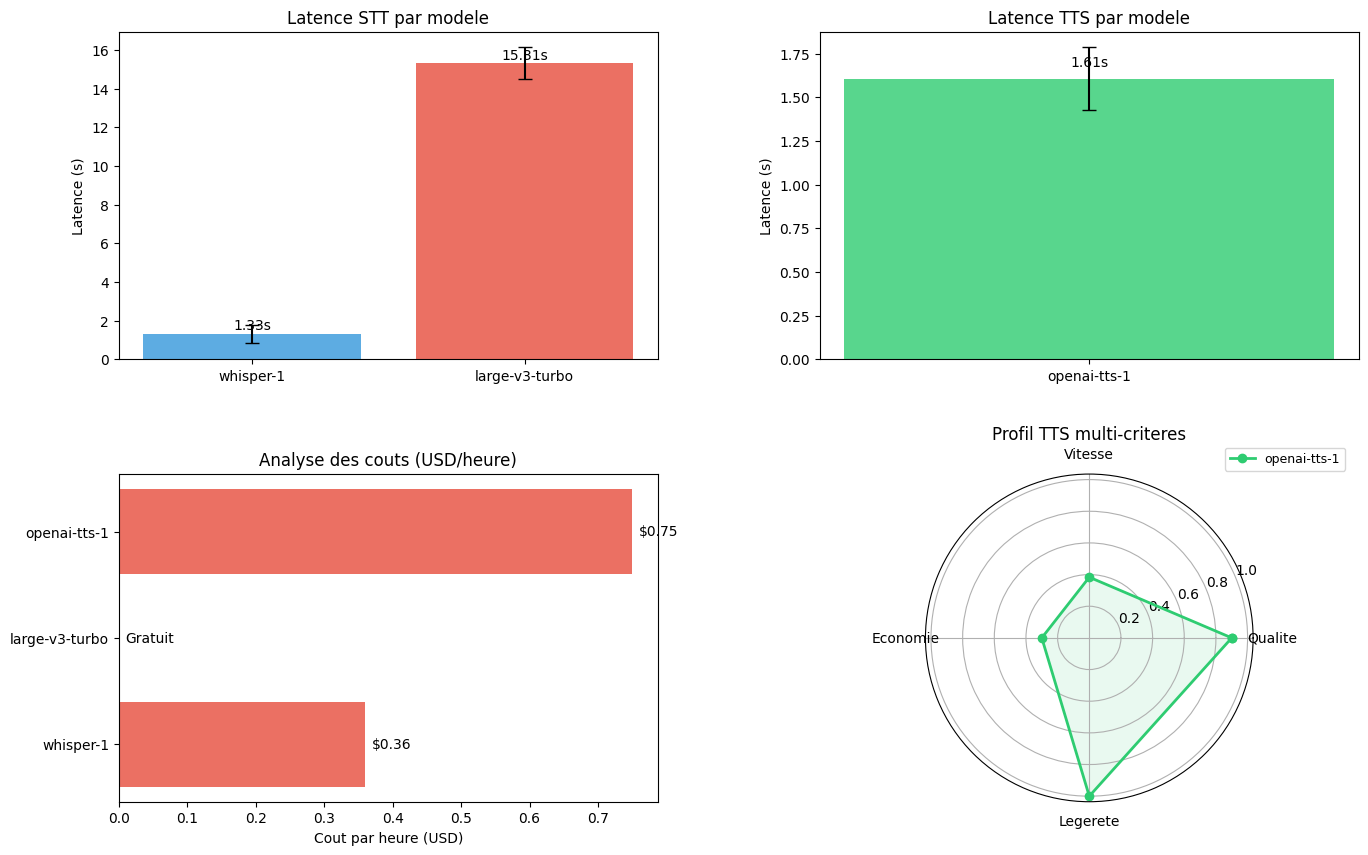

Graphique sauvegarde : benchmark_results.png


In [8]:
# Visualisation des resultats
print("VISUALISATION DES RESULTATS")
print("=" * 45)

try:
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, hspace=0.35, wspace=0.3)

    # --- 1. Bar chart latence STT ---
    ax1 = fig.add_subplot(gs[0, 0])
    stt_results = {k: v for k, v in all_results.items() if v.category == "stt"}
    if stt_results:
        names = [r.model_name for r in stt_results.values()]
        latencies = [r.avg_latency for r in stt_results.values()]
        errors = [r.std_latency for r in stt_results.values()]
        colors = ['#3498db', '#e74c3c']
        bars = ax1.bar(names, latencies, yerr=errors, color=colors[:len(names)], capsize=5, alpha=0.8)
        ax1.set_ylabel('Latence (s)')
        ax1.set_title('Latence STT par modele')
        for bar, lat in zip(bars, latencies):
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                    f'{lat:.2f}s', ha='center', va='bottom', fontsize=10)
    else:
        ax1.text(0.5, 0.5, 'Pas de resultats STT', ha='center', va='center', transform=ax1.transAxes)

    # --- 2. Bar chart latence TTS ---
    ax2 = fig.add_subplot(gs[0, 1])
    tts_results = {k: v for k, v in all_results.items() if v.category == "tts"}
    if tts_results:
        names = [r.model_name for r in tts_results.values()]
        latencies = [r.avg_latency for r in tts_results.values()]
        errors = [r.std_latency for r in tts_results.values()]
        colors = ['#2ecc71', '#f39c12', '#9b59b6']
        bars = ax2.bar(names, latencies, yerr=errors, color=colors[:len(names)], capsize=5, alpha=0.8)
        ax2.set_ylabel('Latence (s)')
        ax2.set_title('Latence TTS par modele')
        for bar, lat in zip(bars, latencies):
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                    f'{lat:.2f}s', ha='center', va='bottom', fontsize=10)
    else:
        ax2.text(0.5, 0.5, 'Pas de resultats TTS', ha='center', va='center', transform=ax2.transAxes)

    # --- 3. Analyse des couts (bar chart) ---
    ax3 = fig.add_subplot(gs[1, 0])
    all_names = []
    all_costs = []
    cost_colors = []
    for k, r in all_results.items():
        all_names.append(r.model_name)
        # Normaliser : cout pour 1 heure d'utilisation
        if r.category == "stt":
            hourly_cost = r.cost_per_unit * 60  # 60 minutes
        else:
            hourly_cost = r.cost_per_unit * 50  # ~50K caracteres/heure
        all_costs.append(hourly_cost)
        cost_colors.append('#e74c3c' if hourly_cost > 0 else '#2ecc71')
    if all_names:
        bars = ax3.barh(all_names, all_costs, color=cost_colors, alpha=0.8)
        ax3.set_xlabel('Cout par heure (USD)')
        ax3.set_title('Analyse des couts (USD/heure)')
        for bar, cost in zip(bars, all_costs):
            label = f'${cost:.2f}' if cost > 0 else 'Gratuit'
            ax3.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2.,
                    label, ha='left', va='center', fontsize=10)

    # --- 4. Radar plot TTS (qualite, vitesse, cout, VRAM) ---
    ax4 = fig.add_subplot(gs[1, 1], polar=True)
    if tts_results:
        categories_radar = ['Qualite', 'Vitesse', 'Economie', 'Legerete']
        N = len(categories_radar)
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]

        radar_colors = ['#2ecc71', '#f39c12', '#9b59b6']
        for idx, (k, r) in enumerate(tts_results.items()):
            # Normaliser chaque metrique sur 0-1
            quality = r.quality_score / 5.0  # MOS max = 5
            speed = 1.0 / (1.0 + r.avg_latency)  # inverse de la latence
            economy = 1.0 if r.cost_per_unit == 0 else 0.3  # gratuit = 1.0
            lightness = 1.0 / (1.0 + r.vram_mb / 1000)  # inverse de la VRAM

            values = [quality, speed, economy, lightness]
            values += values[:1]

            ax4.plot(angles, values, 'o-', linewidth=2, label=r.model_name,
                    color=radar_colors[idx % len(radar_colors)])
            ax4.fill(angles, values, alpha=0.1, color=radar_colors[idx % len(radar_colors)])

        ax4.set_xticks(angles[:-1])
        ax4.set_xticklabels(categories_radar)
        ax4.set_title('Profil TTS multi-criteres')
        ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    else:
        ax4.text(0, 0, 'Pas de resultats TTS', ha='center', va='center')

    plt.savefig(str(OUTPUT_DIR / "benchmark_results.png"), dpi=120, bbox_inches='tight')
    plt.show()
    print(f"Graphique sauvegarde : benchmark_results.png")

except ImportError:
    print("matplotlib non disponible pour la visualisation")
except Exception as e:
    print(f"Erreur visualisation : {type(e).__name__} - {str(e)[:150]}")

### Interpretation : Visualisation

| Graphique | Ce qu'il montre | Lecture |
|-----------|----------------|--------|
| Bar chart STT | Latence par modele avec ecart-type | Plus bas = plus rapide |
| Bar chart TTS | Latence par moteur TTS | Plus bas = plus rapide |
| Couts horaires | Comparaison economique | Vert = gratuit, Rouge = payant |
| Radar TTS | Profil multi-criteres normalise | Plus grand = meilleur |

**Points cles** :
1. Le radar plot permet de voir les forces et faiblesses de chaque modele en un coup d'oeil
2. Les modeles locaux dominent sur l'axe economie mais peuvent perdre en qualite
3. Le choix optimal depend du cas d'usage (temps reel vs batch, budget vs qualite)

In [9]:
# Mode interactif - Choix des modeles a comparer
if notebook_mode == "interactive" and not skip_widgets:
    print("MODE INTERACTIF - COMPARAISON PERSONNALISEE")
    print("=" * 50)
    print("\nChoisissez les modeles a comparer :")
    print("  STT : whisper-1, large-v3-turbo")
    print("  TTS : openai, chatterbox, kokoro")
    print("(Laissez vide pour passer a la suite)")

    try:
        user_text = input("\nTexte personnalise pour TTS (ou vide) : ")

        if user_text.strip():
            print(f"\nGeneration avec les modeles TTS disponibles...")
            for k, r in all_results.items():
                if r.category == "tts":
                    print(f"\n  {r.model_name} : resultats du benchmark")
                    print(f"    Latence moyenne : {r.avg_latency:.2f}s")
                    print(f"    Qualite estimee : {r.quality_score:.1f}/5.0")
                    if r.output_data is not None and isinstance(r.output_data, np.ndarray):
                        display(Audio(data=r.output_data, rate=r.sample_rate))

            print(f"\nPour une comparaison sur votre texte, re-executez")
            print(f"le notebook avec un texte modifie dans la cellule de test.")
        else:
            print("Mode interactif ignore")

    except (KeyboardInterrupt, EOFError):
        print("Mode interactif interrompu")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("Mode interactif non disponible (execution automatisee)")
        else:
            print(f"Erreur : {error_type} - {str(e)[:100]}")
else:
    print("Mode batch - Interface interactive desactivee")

MODE INTERACTIF - COMPARAISON PERSONNALISEE

Choisissez les modeles a comparer :
  STT : whisper-1, large-v3-turbo
  TTS : openai, chatterbox, kokoro
(Laissez vide pour passer a la suite)
Mode interactif non disponible (execution automatisee)


## Guide de decision et bonnes pratiques

### Arbre de decision pour le choix du modele

| Critere | Recommandation STT | Recommandation TTS |
|---------|-------------------|--------------------|
| Budget limite | faster-whisper local | Kokoro ou Chatterbox |
| Qualite maximale | Whisper API | OpenAI tts-1-hd |
| Temps reel | faster-whisper (GPU) | Kokoro (plus leger) |
| Hors-ligne | faster-whisper | Kokoro ou Chatterbox |
| Emotions/prosodie | N/A | Chatterbox |
| Voice cloning | N/A | Chatterbox ou XTTS |
| Production a grande echelle | faster-whisper | Kokoro (leger) |

### Estimation des couts mensuels

| Usage | Volume | Cout API | Cout local (electricite) |
|-------|--------|----------|-------------------------|
| Prototype | 10 min/jour | ~$2/mois | ~$0 |
| Application | 1h/jour | ~$15/mois | ~$5/mois (GPU) |
| Production | 10h/jour | ~$150/mois | ~$30/mois (GPU) |

In [10]:
# Statistiques de session et prochaines etapes
print("STATISTIQUES DE SESSION")
print("=" * 45)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Device : {device}")
print(f"Modeles STT testes : {[r.model_name for r in all_results.values() if r.category == 'stt']}")
print(f"Modeles TTS testes : {[r.model_name for r in all_results.values() if r.category == 'tts']}")
print(f"Runs par modele : {num_runs}")

if gpu_available:
    vram_current = torch.cuda.memory_allocated(0) / (1024**3)
    print(f"VRAM actuelle : {vram_current:.2f} GB")

# Resume complet
if all_results:
    print(f"\nResume des benchmarks :")
    for k, r in all_results.items():
        print(f"  {r.model_name:<20} : latence={r.avg_latency:.2f}s, qualite={r.quality_score:.2f}")

    # Sauvegarder les resultats en JSON
    if save_results:
        results_json = {k: v.to_dict() for k, v in all_results.items()}
        json_path = OUTPUT_DIR / "benchmark_results.json"
        with open(json_path, 'w') as f:
            json.dump(results_json, f, indent=2)
        print(f"\nResultats sauvegardes : {json_path}")

if save_results:
    saved = list(OUTPUT_DIR.glob('*'))
    total_size = sum(f.stat().st_size for f in saved if f.is_file()) / (1024*1024)
    print(f"Fichiers sauvegardes : {len(saved)} ({total_size:.1f} MB) dans {OUTPUT_DIR}")

# Liberation memoire
gc.collect()
if gpu_available:
    torch.cuda.empty_cache()
    print(f"Memoire GPU liberee")

print(f"\nPROCHAINES ETAPES")
print(f"1. Construire des pipelines audio complets STT->LLM->TTS (03-2)")
print(f"2. Explorer l'API Realtime d'OpenAI pour la voix (03-3)")
print(f"3. Creer du contenu educatif audio automatise (04-1)")

print(f"\nNotebook Comparaison Multi-Modeles termine - {datetime.now().strftime('%H:%M:%S')}")

STATISTIQUES DE SESSION
Date : 2026-02-18 10:49:56
Device : cpu
Modeles STT testes : ['whisper-1', 'large-v3-turbo']
Modeles TTS testes : ['openai-tts-1']
Runs par modele : 3

Resume des benchmarks :
  whisper-1            : latence=1.33s, qualite=0.00
  large-v3-turbo       : latence=15.31s, qualite=0.00
  openai-tts-1         : latence=1.61s, qualite=4.50

Resultats sauvegardes : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\audio\comparison\benchmark_results.json
Fichiers sauvegardes : 4 (1.2 MB) dans D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\audio\comparison

PROCHAINES ETAPES
1. Construire des pipelines audio complets STT->LLM->TTS (03-2)
2. Explorer l'API Realtime d'OpenAI pour la voix (03-3)
3. Creer du contenu educatif audio automatise (04-1)

Notebook Comparaison Multi-Modeles termine - 10:49:57
